In [201]:
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras import layers
from tensorflow.data.experimental import AUTOTUNE
import numpy as np
import matplotlib.pyplot as plt
from random import randint
import time
import datetime
import os

In [202]:
## HYPERPARAMETERS
# Data
BATCH_SIZE = 64
SHUFFLE_BUFFER = 1000
CACHE_PATH = "/content/drive/MyDrive/cache/LSTM_Seq/"

In [203]:
if not os.path.exists(CACHE_PATH):
    os.makedirs(CACHE_PATH[:-1])

In [204]:
def onehot_most_frequent(sequence, context):
    onehot = lambda idx: tf.cast(tf.one_hot(idx, 3), tf.int32)

    # if both occour equal often its case 3
    if sequence.count(context[0]) == sequence.count(context[1]):
        return onehot(2)

    idx = int(sequence.count(context[0]) < sequence.count(context[1]))
    return onehot(idx)

In [205]:
def get_context():
    '''Returns two distinct random integers between 0-9'''
    a = randint(0,9)
    b = randint(0,9)
    while a == b:
      b = randint(0,9)
    return [a,b]

In [206]:
def get_data(n_samples=10000, seq_len=25):
    for _ in range(n_samples):
        sequence = [randint(0,9) for _ in range(seq_len)]
        context = get_context()

        label = onehot_most_frequent(sequence, context)

        # one hot and reshape the context digits to easily concat it later
        context = tf.reshape(tf.cast(tf.one_hot(context, 10), tf.int32),shape=(-1,))
        # finaly convert all lists to tensors
        yield tf.convert_to_tensor(sequence, tf.int32), tf.convert_to_tensor(context, tf.int32), label

In [207]:
# for i in get_data(10):
#     print(i)

In [208]:
def build_pipeline(data_size, batchsize, shuffle_buffer):
    # set up dataset from the generator
    ds = tf.data.Dataset.from_generator(lambda: get_data(data_size), output_signature=(
        tf.TensorSpec(shape=(25,), dtype=tf.int32),
        tf.TensorSpec(shape=(20,), dtype=tf.int32),
        tf.TensorSpec(shape=(3,), dtype=tf.int32),
    ))

    # onehot the sequence
    ds = ds.map(lambda seq, con, label: (tf.one_hot(seq, 10), con, label),
                num_parallel_calls=AUTOTUNE)
    
    ds = ds.cache(CACHE_PATH)

    ds = ds.shuffle(buffer_size=shuffle_buffer)
    ds = ds.batch(batchsize, drop_remainder=True)

    ds = ds.prefetch(AUTOTUNE)

    return ds

In [209]:
training_ds = build_pipeline(BATCH_SIZE*1500, BATCH_SIZE, SHUFFLE_BUFFER)
test_ds = build_pipeline(2000, BATCH_SIZE, SHUFFLE_BUFFER)

In [211]:
# for x in training_ds.take(1):
#     print(x)

In [212]:
class LSTM_Cell(Model):
    def __init__(self, units):
        super(LSTM_Cell, self).__init__()
        
        self.preprocess_layer = layers.Dense(units, activation="sigmoid")
        self.forget_layer = layers.Dense(units, activation="sigmoid", bias_initializer="ones")
        self.input_layer = layers.Dense(units, activation="sigmoid")
        self.candidate_layer = layers.Dense(units, activation="tanh")
        self.output_layer = layers.Dense(units, activation="sigmoid")
        self.tanh = tf.keras.activations.tanh

    @tf.function
    def call(self, prev_ht, prev_ct, input):
        input = self.preprocess_layer(input)

        combine = tf.concat([tf.cast(prev_ht, tf.float32), tf.cast(input, tf.float32)], axis=-1)

        # gates
        ft = self.forget_layer(combine)

        candidate = self.candidate_layer(combine)

        it = self.input_layer(combine)

        # outputs
        Ct = tf.add(tf.multiply(prev_ct, ft), tf.multiply(candidate, it))

        ot = self.output_layer(combine)

        ht = tf.multiply(ot, self.tanh(Ct))

        return ht, Ct

In [213]:
class LSTM(Model):
    def __init__(self, latent_size, seq_len, unroll=False):
        super(LSTM, self).__init__()
        self.seq_len = seq_len
        self.unroll = unroll

        self.input_layer = layers.Dense(latent_size, activation="tanh", input_shape=(BATCH_SIZE, 10))
        self.readout_layer = layers.Dense(3, activation="softmax")

        self.lstm_cell = LSTM_Cell(latent_size)
        self.reset = tf.zeros(shape=(64,latent_size), dtype=tf.float32)

    @tf.function
    def call(self, seq, cont):
        # reset memory before encountering new sequences
        x = None
        h = self.reset
        c = self.reset

        accumulator = tf.TensorArray(tf.float32, size=self.seq_len, element_shape=(BATCH_SIZE, 3), dynamic_size=True)

        # let's feed one digit per timestep into the network incl. the two querries
        for i in range(self.seq_len):
            x = tf.concat([tf.cast(cont, tf.float32), tf.cast(seq[:,i,:], tf.float32)], -1)
            x = self.input_layer(x)
            
            h, c = self.lstm_cell(h, c, x)

            if self.unroll:
                x = self.readout_layer(h)
                accumulator = accumulator.write(i, x)

        if not self.unroll:
            x = self.readout_layer(h)
            return x

        return accumulator.stack()
        

In [220]:
# cell = LSTM(30, 25, False)
# for seq, context, label in training_ds.take(1):
#     print(seq.shape)
#     print(context.shape)
#     print(cell(seq, context).shape)

In [215]:
@tf.function
def train_step(model, seq, cont, target, loss_function, optimizer):
    
    # loss_object and optimizer_object are instances of respective tensorflow classes
    with tf.GradientTape() as tape:
        prediction = model(seq, cont)
        loss = loss_function(target, prediction)
        gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    # accuracy
    acc = tf.argmax(target, axis=1) == tf.argmax(prediction, axis=1)
    acc = tf.reduce_mean(tf.cast(acc, tf.float32))  

    return tf.reduce_mean(loss), acc


def test(model, data):
    '''tests the accuracy of the model on the data'''
    accummulator = []
    for seq, cont, label in data:
        pred = model(seq, cont)
        acc = tf.argmax(label, axis=1) == tf.argmax(pred, axis=1)
        acc = tf.reduce_mean(tf.cast(acc, tf.float32))
        accummulator.append(acc)
    return np.mean(accummulator)


In [216]:
def train(model, steps=5000, print_every=500, running_average_factor = 0.95):
    
    optimizer = tf.keras.optimizers.Adam()
    cross_entropy_loss = tf.keras.losses.MSE

    losses = []
    acces = []

    running_average_loss = 0
    running_average_acc = 0
    i=0

    for i in range(steps):
        # generating a new sample in each training step
        for seq, cont, target in training_ds:
            loss, acc = train_step(model, seq, cont, target, cross_entropy_loss, optimizer)
        
        # compute the running averages of training loss and accuracy
        running_average_loss = running_average_factor * running_average_loss  + (1 - running_average_factor) * loss
        running_average_acc = running_average_factor * running_average_acc  + (1 - running_average_factor) * acc
        losses.append(running_average_loss)
        acces.append(running_average_acc)
        
        if i%print_every==0:
            print(f"Training step {i+1}: average loss is {np.round(losses[-1],2)}, accuracy of {np.round(acces[-1], 2)} %")
    return losses, acces

In [217]:
def visualize(losses, acces, name=''):
    plt.figure()
    plt.title(name)
    line1, = plt.plot(losses)
    plt.xlabel("Training steps")
    plt.ylabel("Loss")
    plt.show()
    plt.figure()
    line1, = plt.plot(acces)
    plt.xlabel("Training steps")
    plt.ylabel("Accuracy")
    plt.show()

Training step 1: average loss is 0.009999999776482582, accuracy of 0.019999999552965164 %
Training step 2: average loss is 0.019999999552965164, accuracy of 0.05000000074505806 %
Training step 3: average loss is 0.029999999329447746, accuracy of 0.07000000029802322 %
Training step 4: average loss is 0.03999999910593033, accuracy of 0.09000000357627869 %
Training step 5: average loss is 0.03999999910593033, accuracy of 0.11999999731779099 %
Training step 6: average loss is 0.05000000074505806, accuracy of 0.15000000596046448 %
Training step 7: average loss is 0.03999999910593033, accuracy of 0.1899999976158142 %
Training step 8: average loss is 0.03999999910593033, accuracy of 0.23000000417232513 %
Training step 9: average loss is 0.03999999910593033, accuracy of 0.25999999046325684 %
Training step 10: average loss is 0.03999999910593033, accuracy of 0.30000001192092896 %
Training step 11: average loss is 0.03999999910593033, accuracy of 0.33000001311302185 %
Training step 12: average l

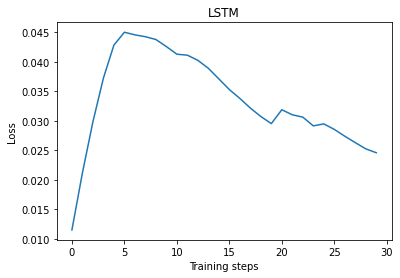

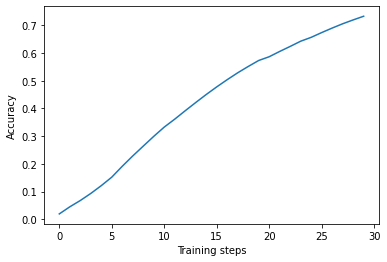

In [218]:
model = LSTM(30, 25)
losses, acces = train(model,30,1)
visualize(losses, acces, 'LSTM')

In [219]:
test(model, test_ds)

0.9788854